In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np

from pylops.basicoperators import *
from pylops.optimization.sparsity import fista
from pylops.utils.metrics import snr
from pylops.basicoperators import FirstDerivative, Diagonal
from pylops.signalprocessing import FFT2D

from landmc.preprocessing import mask, mask_cut, subsample, fk_transform, fk_filter_design,plot_reconstruction_2d_real
from landmc.nmoinv import NMO
from landmc.slopes import multicomponent_slopes_inverse
from landmc.MCReconstruction import MCdata

import matplotlib.pyplot as plt
import cupy as cp
cp_asarray = cp.asarray
cp_asnumpy = cp.asnumpy

apply_nmo = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# slope estimation
eps_slopeest = 5e3# regularization factor for smoothing
niter_slopeest = 5e3 # number of iterations of lsqr

#Plotting Params
clip_v = 5e-2
clip_fk = 3e-2
fk_uplim = 160
clip_slope = 1e-3
save_fig_folder = "../figures/"

## Load data

In [4]:
#Load data
file = np.load("../data/StrydeGradient_preprocessed.npz")
data = file['rec1']
d1_data = file['d1'].T
sc1 = file['sc1']

#Time and space axis
x = np.arange(0,88,0.5)
t = file['t']  #ms
t-=t[0]
dt = (t[1]-t[0])
dx = x[1]-x[0]

#Put data into the desired dense grid
data_full = np.zeros((data.shape[0]*4,data.shape[1]))
d1_full = np.zeros((data.shape[0]*4,data.shape[1]))
data_full[::4] = data
d1_full[::4] = d1_data

In [5]:
nfft_t, nfft_x = 2**12, 2**12

nx = data.shape[0]
nt = data.shape[1]

D2m,_,_,_ = fk_transform(data, nfft_x, nfft_t, 2, dt)
D, f, ks, Fop = fk_transform(data_full, nfft_x, nfft_t, dx, dt)

In [6]:
#Disp kwargs
show_seis_kwargs = dict(aspect='auto',cmap='seismic',vmin=-clip_v,vmax=clip_v,extent=(x[0]/1000, x[-1]/1000, t[-1], t[10]))
show_fk_kwargs = dict(cmap='gist_ncar_r',aspect='auto', 
                      extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]),vmin=0,vmax=clip_fk)

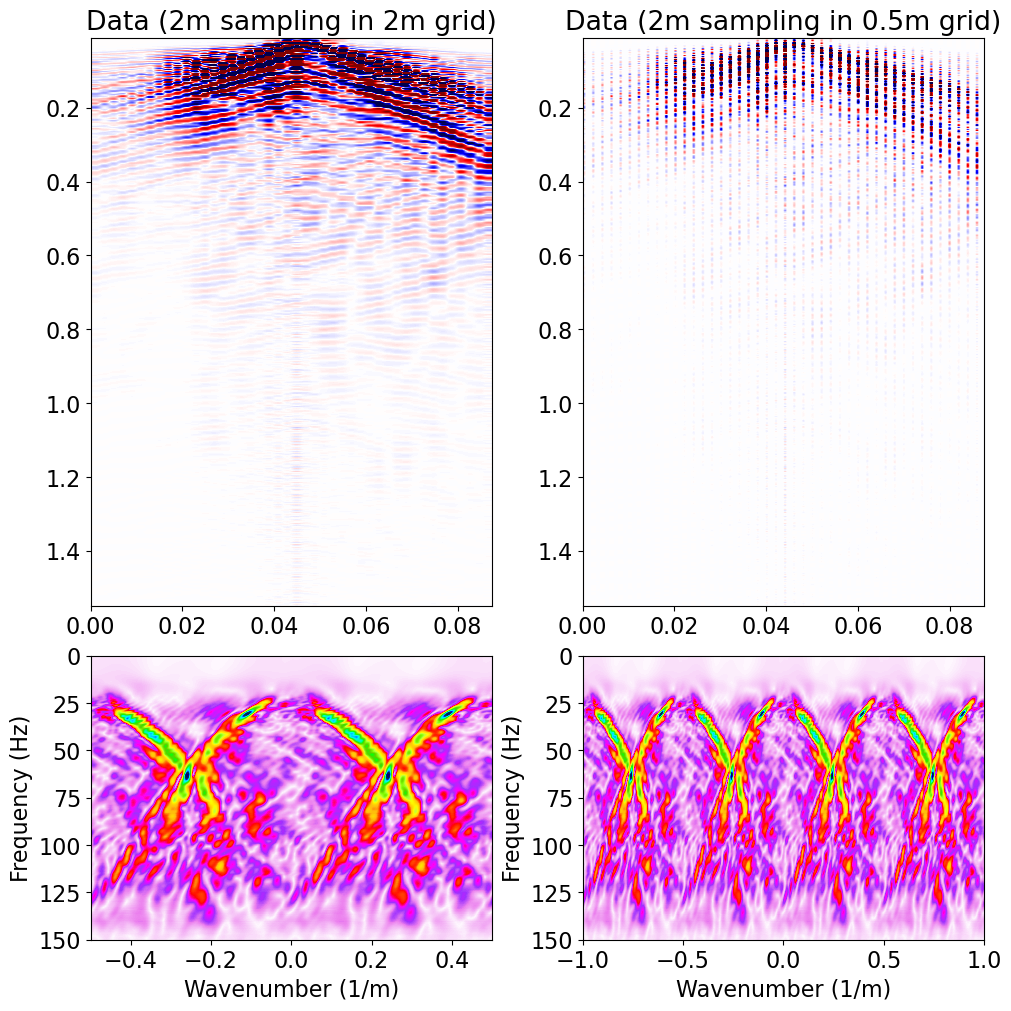

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
axs = []
gs = fig.add_gridspec(3, 2)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[2, 1]))

axs[0].imshow(data.T,**show_seis_kwargs)
axs[0].set_title("Data (2m sampling in 2m grid)")
axs[1].imshow(np.fft.fftshift(np.abs(D).T, axes=1), **show_fk_kwargs)
axs[1].set_xlim(-1/(2), 1/(2))
axs[1].set_ylim(150,0)
axs[1].set_xlabel("Wavenumber (1/m)")
axs[1].set_ylabel("Frequency (Hz)")

axs[2].imshow(data_full.T,**show_seis_kwargs)
axs[2].set_title("Data (2m sampling in 0.5m grid)")
axs[3].imshow(np.fft.fftshift(np.abs(D).T, axes=1), **show_fk_kwargs)
axs[3].set_xlim(-1/(2*dx), 1/(2*dx))
axs[3].set_ylim(150,0)
axs[3].set_xlabel("Wavenumber (1/m)")
axs[3].set_ylabel("Frequency (Hz)")
plt.show()

## Decimating Data

In [8]:
#Decimate Data
data_obs2m, data_mask2m, Rop2m = subsample(data_full,nsub=4)
data_mask2m = data_mask2m.data

data_obs4m, data_mask4m, Rop4m = subsample(data_full,nsub=8)
data_mask4m = data_mask4m.data

#Decimate Derivative
d1_2m,_,_ = subsample(d1_full,nsub=4)
d1_4m,_,_ = subsample(d1_full,nsub=8)

# apply FK transform to data
D_sub = Fop * data_mask2m

# Compute derivatives in FK domain
ks_d1 = np.fft.fftfreq(nfft_x, dx)
coeff1 = 1j * 2 * np.pi * ks_d1
coeff1 = np.repeat(coeff1[:, np.newaxis], nfft_t//2+1, axis=1).ravel()
D1op = Diagonal(coeff1)

sc1 = np.max(np.abs(data_obs2m)) / np.max(np.abs(d1_2m))

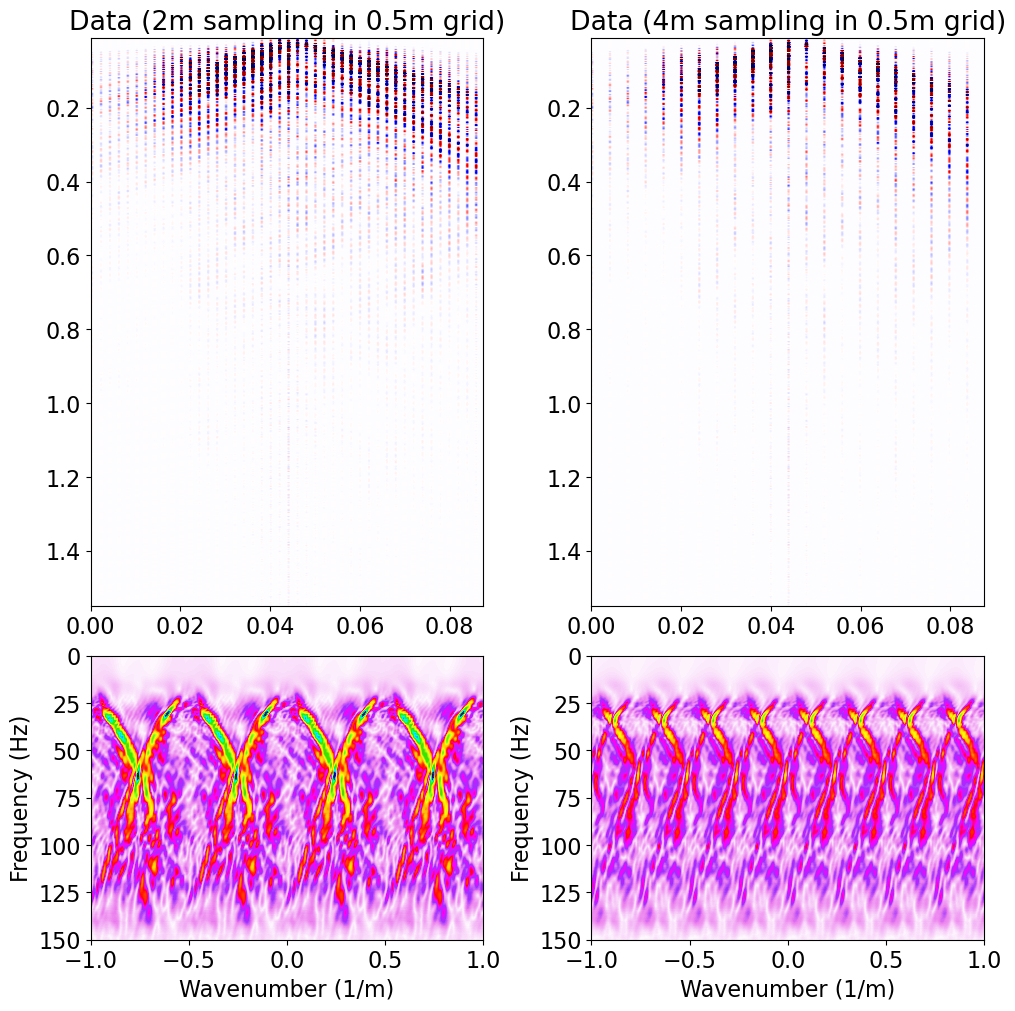

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
axs = []
gs = fig.add_gridspec(3, 2)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[2, 1]))

axs[0].imshow(data_mask2m.T,**show_seis_kwargs)
axs[0].set_title("Data (2m sampling in 0.5m grid)")
axs[1].imshow(np.fft.fftshift(np.abs(D).T, axes=1), **show_fk_kwargs)
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_ylim(150,0)
axs[1].set_xlabel("Wavenumber (1/m)")
axs[1].set_ylabel("Frequency (Hz)")

axs[2].imshow(data_mask4m.T,**show_seis_kwargs)
axs[2].set_title("Data (4m sampling in 0.5m grid)")
axs[3].imshow(np.fft.fftshift(np.abs(Fop*data_mask4m).T, axes=1), **show_fk_kwargs)
axs[3].set_xlim(-1/(2*dx), 1/(2*dx))
axs[3].set_ylim(150,0)
axs[3].set_xlabel("Wavenumber (1/m)")
axs[3].set_ylabel("Frequency (Hz)")
plt.show()

## Separating Direct/Refraction wave with Groundroll

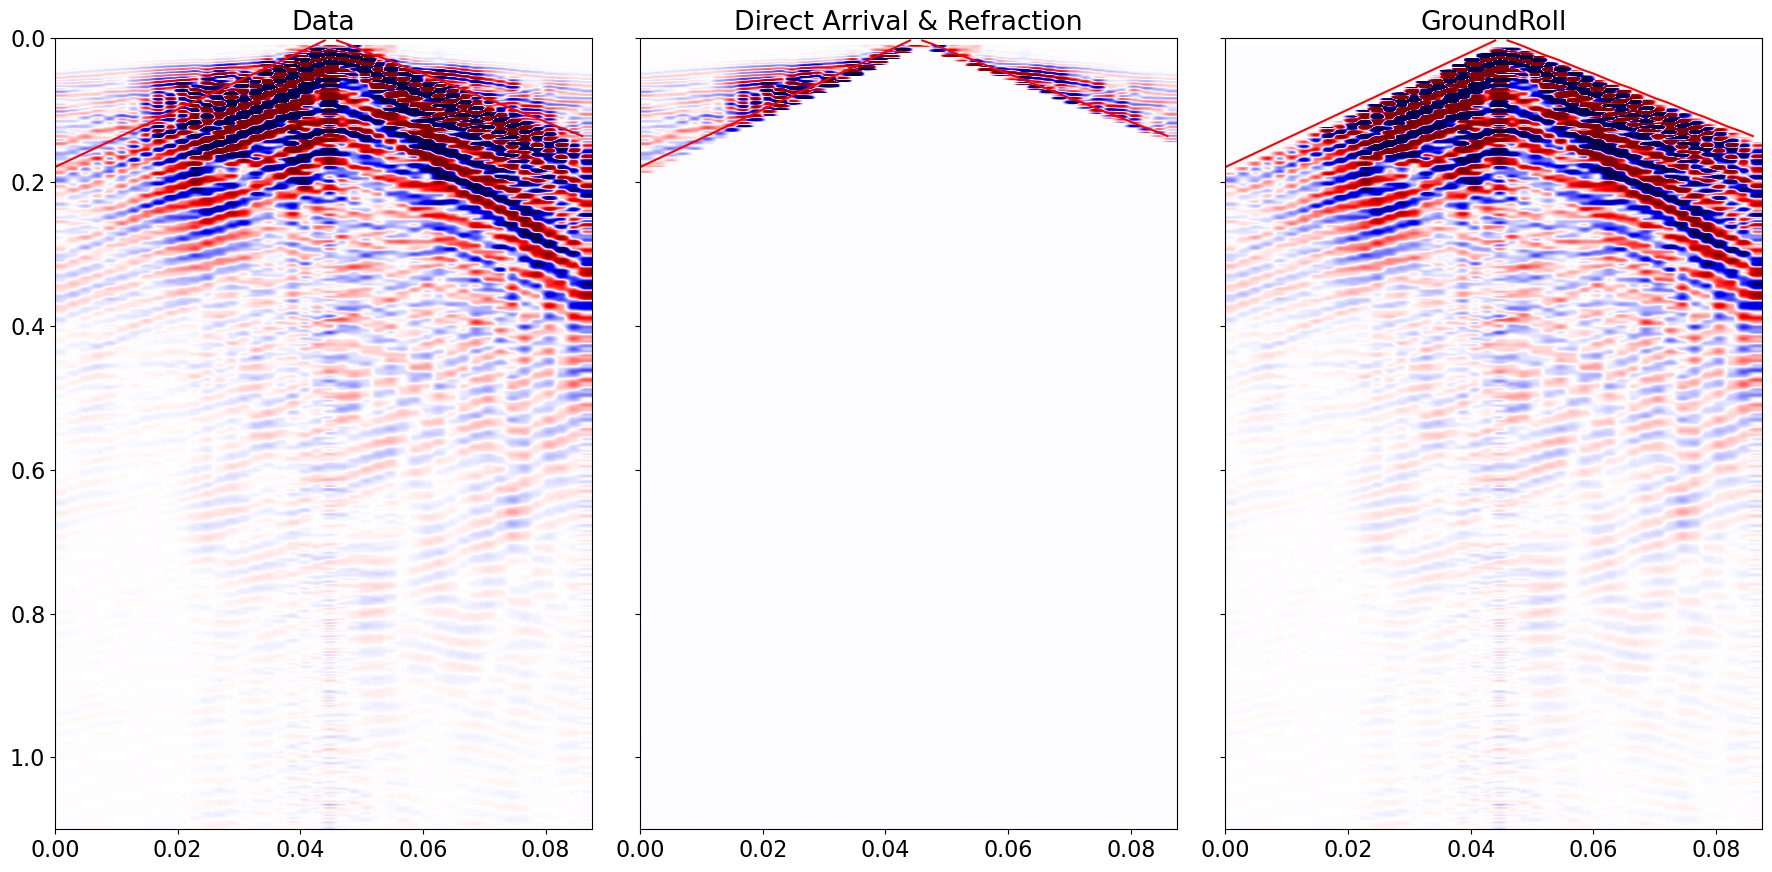

In [10]:
def mask_cut(data,vcut,t,dt,offset,it0=0,cut='up'):
    #Mute direct and refracted wave
    pcut = 1/vcut
    data_cut = data.copy()
    nx = len(offset)

    ix = np.arange(nx)
    tevent = t[0] + offset * pcut
    tevent = (tevent - t[0]) / dt
    itevent = tevent.astype(int)+it0
    mask = (itevent < nt - 1) & (itevent >= it0)
    for i in range(nx):
        #For every trace
        if i<len(itevent[mask]):
            if cut=='up':
                data_cut[ix[mask][i],:itevent[mask][i]] = 0
            elif cut=='down':
                data_cut[ix[mask][i],itevent[mask][i]:] = 0
    #     else:
    #         data_cut[i,:nt]=0
    
    return data_cut,mask,itevent

vdown1 = 300
vdown2 = 250

#Separate the 2m data
offsetleft = -(x[::4]-x[data_full.shape[0]//2+2])
offsetright = x[::4]-x[data_full.shape[0]//2+2]

data_cut2m,mask2,itevent2 = mask_cut(data_obs2m,vdown1,t,dt,offsetright,cut='down')
data_cut2m,mask4,itevent4 = mask_cut(data_cut2m,vdown2,t,dt,offsetleft,cut='down')
d1_cut2m,mask2,itevent2 = mask_cut(d1_2m,vdown1,t,dt,offsetright,cut='down')
d1_cut2m,mask4,itevent4 = mask_cut(d1_cut2m,vdown2,t,dt,offsetleft,cut='down')

data_GR2m = data_obs2m - data_cut2m
data_noGR2m = data_cut2m
d1_GR2m = d1_2m - d1_cut2m
d1_noGR2m = d1_cut2m

offsetright = offsetright + x[data_full.shape[0]//2+2]
offsetleft = -(offsetleft-x[data_full.shape[0]//2+2])

#Separate the 4m data
offsetleft = -(x[::8]-x[data_full.shape[0]//2+2])
offsetright = x[::8]-x[data_full.shape[0]//2+2]

data_cut4m,_,_ = mask_cut(data_obs4m,vdown1,t,dt,offsetright,cut='down')
data_cut4m,_,_ = mask_cut(data_cut4m,vdown2,t,dt,offsetleft,cut='down')
d1_cut4m,_,_ = mask_cut(d1_4m,vdown1,t,dt,offsetright,cut='down')
d1_cut4m,_,_ = mask_cut(d1_cut4m,vdown2,t,dt,offsetleft,cut='down')

data_GR4m = data_obs4m - data_cut4m
data_noGR4m = data_cut4m
d1_GR4m = d1_4m - d1_cut4m
d1_noGR4m = d1_cut4m

offsetleft = -(x[::4]-x[data_full.shape[0]//2+2])
offsetright = x[::4]-x[data_full.shape[0]//2+2]
offsetright = offsetright + x[data_full.shape[0]//2+2]
offsetleft = -(offsetleft-x[data_full.shape[0]//2+2])


fig,axs = plt.subplots(1,3,figsize=(18,9),sharey=True)
axs[0].imshow(data_obs2m.T,  **show_seis_kwargs)
axs[0].set_ylim((1.1,0))
axs[0].set_title("Data")

axs[0].plot(offsetleft[mask2]/1000,itevent2[mask2]*dt,c='red')
axs[0].plot(offsetright[mask4]/1000,itevent4[mask4]*dt,c='red')

axs[1].imshow(data_cut2m.T,  **show_seis_kwargs)
axs[1].set_title("Direct Arrival & Refraction")

axs[1].plot(offsetleft[mask2]/1000,itevent2[mask2]*dt,c='red')
axs[1].plot(offsetright[mask4]/1000,itevent4[mask4]*dt,c='red')

axs[2].imshow(data_GR2m.T,  **show_seis_kwargs)
axs[2].set_title("GroundRoll")

axs[2].plot(offsetleft[mask2]/1000,itevent2[mask2]*dt,c='red')
axs[2].plot(offsetright[mask4]/1000,itevent4[mask4]*dt,c='red')
plt.tight_layout()
plt.show()

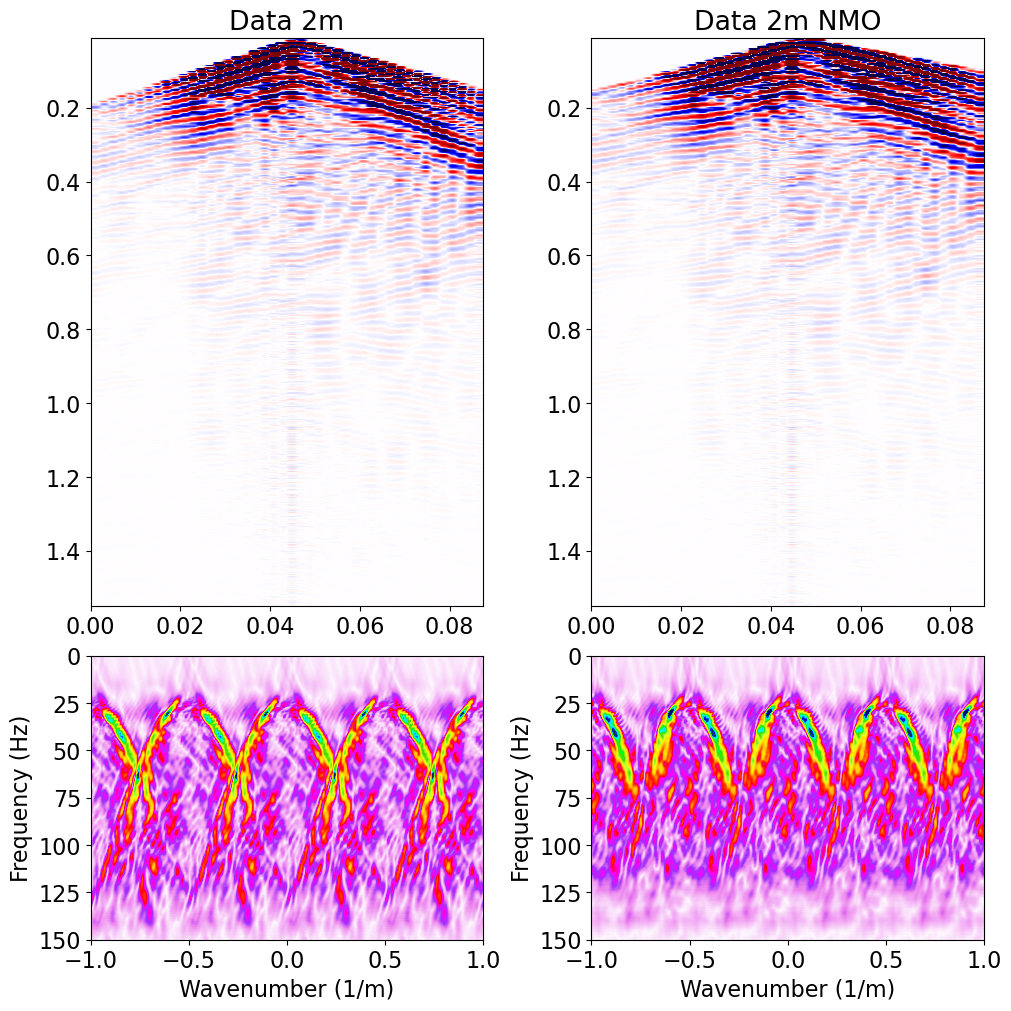

In [11]:
#NMO Correction
if apply_nmo:
    vnmo = 400
    #2m nmo
    x_obs = x[::4]
    x_mid = x_obs[len(x_obs)//2]
    NMOoporig = NMO(t,x-x_mid,vnmo*np.ones(nt))
    NMOop = NMO(t,x_obs-x_mid,vnmo*np.ones(nt))
    data_GR2mnonmo = data_GR2m
    data_GR2m = NMOop @ data_GR2m
    d1_GR2m = NMOop @ d1_GR2m
    
    #4m nmo
    x_obs = x[::8]
    x_mid = x_obs[len(x_obs)//2]
    NMOop = NMO(t,x_obs-x_mid,vnmo*np.ones(nt))
    data_GR4m = NMOop @ data_GR4m
    d1_GR4m = NMOop @ d1_GR4m
    
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
axs = []
gs = fig.add_gridspec(3, 2)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[2, 1]))

axs[0].imshow(data_GR2mnonmo.T,**show_seis_kwargs)
axs[0].set_title("Data 2m")
axs[1].imshow(np.fft.fftshift(np.abs(Fop*Rop2m.H*data_GR2mnonmo).T, axes=1), **show_fk_kwargs)
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_ylim(150,0)
axs[1].set_xlabel("Wavenumber (1/m)")
axs[1].set_ylabel("Frequency (Hz)")

axs[2].imshow(data_GR2m.T,**show_seis_kwargs)
axs[2].set_title("Data 2m NMO")
axs[3].imshow(np.fft.fftshift(np.abs(Fop*Rop2m.H*data_GR2m).T, axes=1), **show_fk_kwargs)
axs[3].set_xlim(-1/(2*dx), 1/(2*dx))
axs[3].set_ylim(150,0)
axs[3].set_xlabel("Wavenumber (1/m)")
axs[3].set_ylabel("Frequency (Hz)")
plt.show()

## Set up F-K Mask

In [12]:
# F-K Mask
vel = 190. # velocity
fmax = 200 # maximum frequency
critical = 1.00 # scaling to be applied to the f=k*v line used to create the mask
koffset = 0.001 # shift to be applied to the f=k*v line used to create the mask

mask_fk = fk_filter_design(f, ks, vel, fmax, critical=critical, koffset=koffset)
Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex128)

/tmp/ipykernel_549190/454382530.py:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex128)


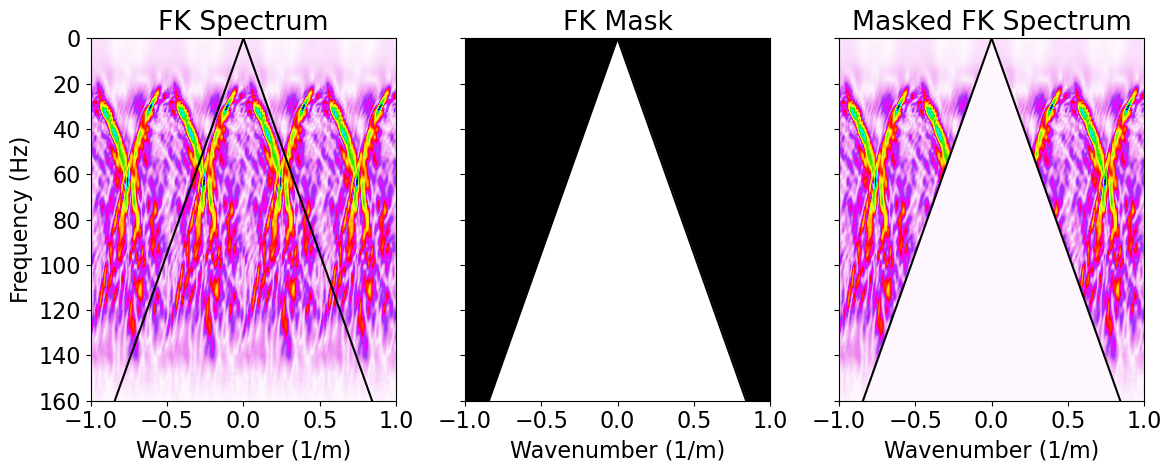

In [13]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
axs[0].imshow(np.fft.fftshift(np.abs(D).T, axes=1), **show_fk_kwargs)

axs[0].plot(f/vel, f,'k'), axs[0].plot(-f/vel, f,'k')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx))
axs[0].set_xlabel('Wavenumber (1/m)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('FK Spectrum')

axs[1].imshow(np.fft.fftshift(mask_fk, axes=1), cmap='gray',aspect='auto',
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))

axs[1].plot(f/vel, f,'k'), axs[1].plot(-f/vel, f,'k')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_xlabel('Wavenumber (1/m)')
axs[1].set_title('FK Mask')

axs[2].imshow(np.fft.fftshift((1-mask_fk)*np.abs(D).T, axes=1), **show_fk_kwargs)

axs[2].plot(f/vel, f,'k'), axs[2].plot(-f/vel, f,'k')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx))
axs[2].set_ylim(fk_uplim, 0)
axs[2].set_xlabel('Wavenumber (1/m)')
axs[2].set_title('Masked FK Spectrum')
plt.tight_layout()

## Set up T-X Mask

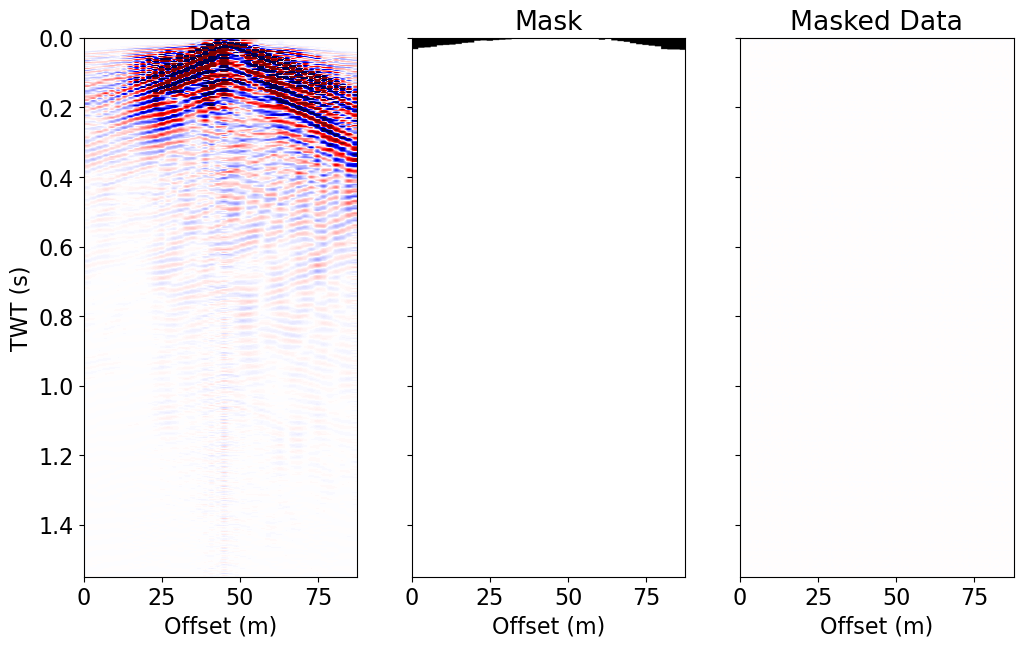

In [14]:
# Calculate time-space mask
# mask_thresh = 0.000001
mask_thresh = 0.0005
maskt2m = mask(Rop2m.H*data_obs2m, mask_thresh,itoff=5)
maskt4m = mask(Rop4m.H*data_obs4m, mask_thresh,itoff=5)
# data_obs = Rop*(maskt*data_mask)
# d1 = Rop*(maskt*d1_mask)
 
fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(data_obs2m.T, cmap='seismic', vmin=-clip_v, vmax=clip_v, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')

axs[1].imshow(maskt2m.T, cmap='gray', vmin=0, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('Mask')
axs[1].axis('tight')

axs[2].imshow((1-(Rop2m * maskt2m).T)*data_GR2m.T, cmap='seismic', vmin=-clip_v*0.1, vmax=clip_v*0.1, extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('Masked Data')
axs[2].axis('tight');

In [16]:
L = 10 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99
mu = 0.99 /(tau*L)
sigma = 1e-4
niterPD = 200

## Reconstruction (2m to 0.5m)

Slope Estimated


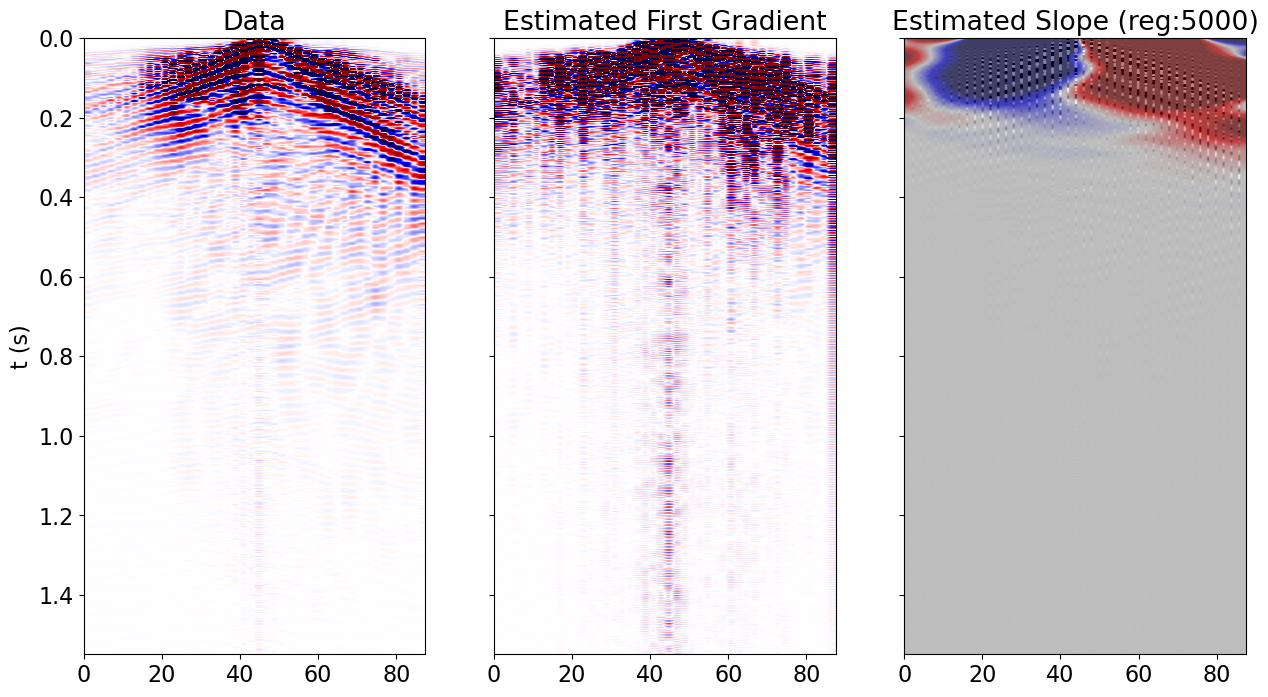

In [17]:
slope_reg_GR = 5000
slope_reg_noGR = 5000
DataGR2m = MCdata(data_GR2m,d1_GR2m,x,t,sc1,Rop2m,D1op,Fop,Mf,4,fulldata_grid=data_full)
DatanoGR2m = MCdata(data_noGR2m,d1_noGR2m,x,t,sc1,Rop2m,D1op,Fop,Mf,4,fulldata_grid=data_full)
DataGR2m.estimate_slope(reg=slope_reg_GR,niter=5000,use_weighted=False)
DatanoGR2m.estimate_slope(reg=slope_reg_noGR,niter=1000,use_weighted=False)
print("Slope Estimated")
fig,axs = plt.subplots(1,3,figsize=(15,8),sharey=True)
axs[0].imshow(data_obs2m.T,aspect='auto',vmin=-clip_v, vmax=clip_v,cmap='seismic',extent=[x[0],x[-1],t[-1],t[0]])
axs[0].set_title("Data")
axs[0].set_ylabel("t (s)")
axs[1].imshow(d1_2m.T,aspect='auto',vmin=-clip_v, vmax=clip_v,cmap='seismic',extent=[x[0],x[-1],t[-1],t[0]])
axs[1].set_title("Estimated First Gradient")
axs[2].imshow(data_mask2m.T,aspect='auto',vmin=-clip_v, vmax=clip_v,cmap='gray',extent=[x[0],x[-1],t[-1],t[0]])
axs[2].imshow(DataGR2m.slope,aspect='auto',cmap='seismic',vmin=-clip_slope,vmax=clip_slope,alpha=0.5,extent=[x[0],x[-1],t[-1],t[0]])
axs[2].set_title("Estimated Slope (reg:%d)"%slope_reg_GR)
plt.show()

In [18]:
xinvGR2m = DataGR2m.MC_inversion_PD(niterPD,sigma,0.5,tau,mu,firstgrad=True)
xinvGR2m = NMOoporig.div(xinvGR2m.ravel()).reshape(data_full.shape)
xinvnoGR2m = DatanoGR2m.MC_inversion_PD(niterPD,sigma,1,tau,mu,firstgrad=True)
xinv2m = xinvGR2m+xinvnoGR2m
print("Done")

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Orthogonal.Orthogonal'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 0.99		mu = 0.09999999999999999
theta = 1.00		niter = 200

   Itn       x[0]          f           g          z^x       J = f + g + z^x


/home/khatamm/anaconda3/envs/landmc/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


     1   2.46933e-04   3.927e-01   4.306e+01   0.000e+00       4.345e+01
     2   2.60235e-04   4.148e-01   4.222e+01   0.000e+00       4.264e+01
     3   3.26385e-04   4.457e-01   4.579e+01   0.000e+00       4.623e+01
     4   4.05152e-04   4.653e-01   4.881e+01   0.000e+00       4.928e+01
     5   4.75195e-04   4.706e-01   4.873e+01   0.000e+00       4.920e+01
     6   5.08934e-04   4.649e-01   4.587e+01   0.000e+00       4.634e+01
     7   4.82284e-04   4.558e-01   4.205e+01   0.000e+00       4.251e+01
     8   4.24277e-04   4.492e-01   3.895e+01   0.000e+00       3.940e+01
     9   3.59410e-04   4.504e-01   3.755e+01   0.000e+00       3.800e+01
    10   3.20485e-04   4.617e-01   3.782e+01   0.000e+00       3.828e+01
    21   1.27643e-04   6.962e-01   3.985e+01   0.000e+00       4.054e+01
    41   7.07657e-06   1.223e+00   4.472e+01   0.000e+00       4.594e+01
    61  -6.44426e-05   1.545e+00   4.950e+01   0.000e+00       5.104e+01
    81  -7.47527e-05   1.576e+00   4.964e+01   0.00

/home/khatamm/anaconda3/envs/landmc/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


     1   5.32244e-04   1.089e-01   4.248e+00   0.000e+00       4.357e+00
     2   9.92127e-04   1.149e-01   4.810e+00   0.000e+00       4.925e+00
     3   1.29864e-03   1.264e-01   5.671e+00   0.000e+00       5.797e+00
     4   1.47073e-03   1.343e-01   6.133e+00   0.000e+00       6.268e+00
     5   1.55358e-03   1.378e-01   6.024e+00   0.000e+00       6.162e+00
     6   1.58197e-03   1.380e-01   5.501e+00   0.000e+00       5.639e+00
     7   1.60651e-03   1.368e-01   4.835e+00   0.000e+00       4.972e+00
     8   1.66855e-03   1.357e-01   4.247e+00   0.000e+00       4.382e+00
     9   1.76542e-03   1.360e-01   3.843e+00   0.000e+00       3.979e+00
    10   1.86193e-03   1.380e-01   3.628e+00   0.000e+00       3.766e+00
    21   4.76656e-04   1.823e-01   3.669e+00   0.000e+00       3.851e+00
    41   1.60899e-04   1.836e-01   4.118e+00   0.000e+00       4.301e+00
    61   5.21918e-05   2.046e-01   4.508e+00   0.000e+00       4.712e+00
    81  -3.83192e-05   2.094e-01   4.795e+00   0.00

## Reconstruction (4m to 0.5m)

Slope Estimated


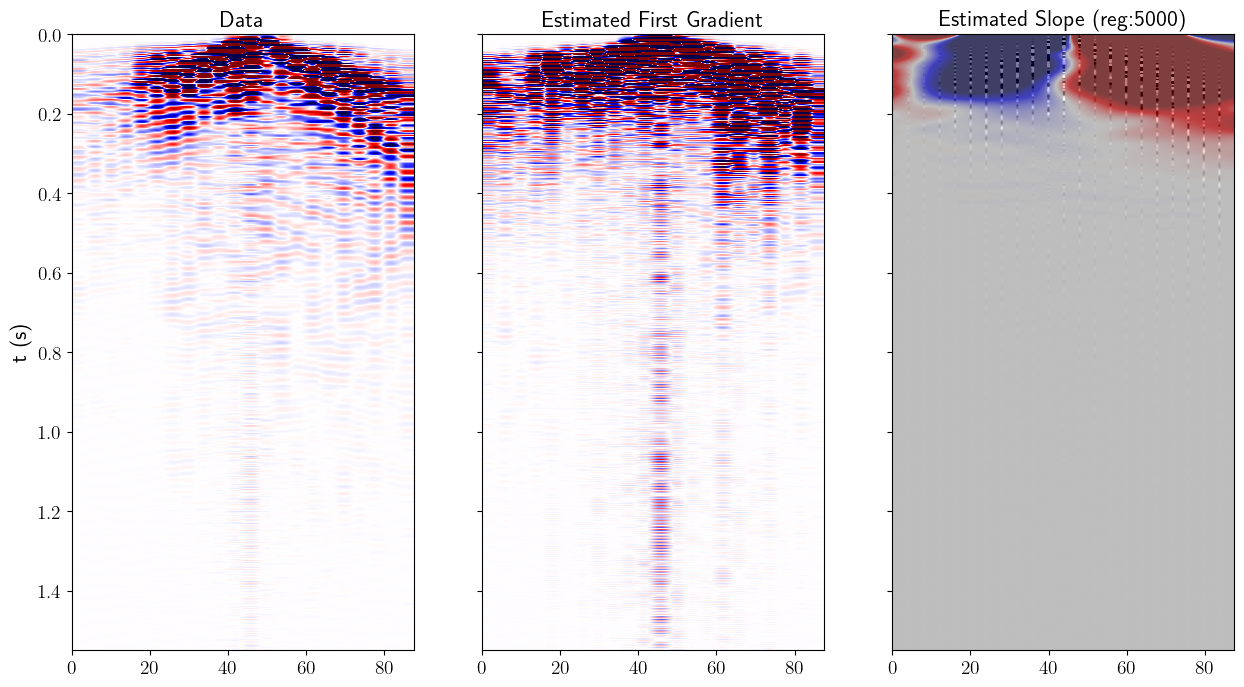

In [22]:
# For 4m data
slope_reg_GR = 5000
slope_reg_noGR = 5000
DataGR4m = MCdata(data_GR4m, d1_GR4m, x, t, sc1, Rop4m, D1op, Fop, Mf, 8, fulldata_grid=data_full)
DatanoGR4m = MCdata(data_noGR4m, d1_noGR4m, x, t, sc1, Rop4m, D1op, Fop, Mf, 8, fulldata_grid=data_full)
DataGR4m.estimate_slope(reg=slope_reg_GR, niter=5000, use_weighted=False)
DatanoGR4m.estimate_slope(reg=slope_reg_noGR, niter=1000, use_weighted=False)
print("Slope Estimated")
fig,axs = plt.subplots(1,3,figsize=(15,8),sharey=True)
axs[0].imshow(data_obs4m.T,aspect='auto',vmin=-clip_v, vmax=clip_v,cmap='seismic',extent=[x[0],x[-1],t[-1],t[0]])
axs[0].set_title("Data")
axs[0].set_ylabel("t (s)")
axs[1].imshow(d1_4m.T,aspect='auto',vmin=-clip_v, vmax=clip_v,cmap='seismic',extent=[x[0],x[-1],t[-1],t[0]])
axs[1].set_title("Estimated First Gradient")
axs[2].imshow(data_mask4m.T,aspect='auto',vmin=-clip_v, vmax=clip_v,cmap='gray',extent=[x[0],x[-1],t[-1],t[0]])
axs[2].imshow(DataGR4m.slope,aspect='auto',cmap='seismic',vmin=-clip_slope,vmax=clip_slope,alpha=0.5,extent=[x[0],x[-1],t[-1],t[0]])
axs[2].set_title("Estimated Slope (reg:%d)"%slope_reg_GR)
plt.show()

In [23]:
xinvGR4m = DataGR4m.MC_inversion_PD(niterPD, sigma, 0.5, tau, mu, firstgrad=True)
xinvGR4m = NMOoporig.div(xinvGR4m.ravel()).reshape(data_full.shape)
xinvnoGR4m = DatanoGR4m.MC_inversion_PD(niterPD, sigma, 1, tau, mu, firstgrad=True)
xinv4m = xinvGR4m + xinvnoGR4m
print("Done")

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Orthogonal.Orthogonal'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 0.99		mu = 0.09999999999999999
theta = 1.00		niter = 200

   Itn       x[0]          f           g          z^x       J = f + g + z^x


/home/khatamm/anaconda3/envs/landmc/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


     1   8.90659e-04   2.957e-01   2.559e+01   0.000e+00       2.589e+01
     2   8.60826e-04   3.142e-01   2.545e+01   0.000e+00       2.576e+01
     3   7.53847e-04   3.380e-01   2.782e+01   0.000e+00       2.815e+01
     4   7.31429e-04   3.508e-01   2.982e+01   0.000e+00       3.017e+01
     5   7.37117e-04   3.505e-01   3.005e+01   0.000e+00       3.040e+01
     6   7.36366e-04   3.403e-01   2.862e+01   0.000e+00       2.896e+01
     7   7.36191e-04   3.263e-01   2.648e+01   0.000e+00       2.681e+01
     8   7.52230e-04   3.141e-01   2.465e+01   0.000e+00       2.496e+01
     9   7.89518e-04   3.075e-01   2.376e+01   0.000e+00       2.407e+01
    10   8.27310e-04   3.094e-01   2.399e+01   0.000e+00       2.430e+01
    21   1.75121e-03   4.344e-01   2.910e+01   0.000e+00       2.953e+01
    41   2.77305e-03   6.915e-01   3.569e+01   0.000e+00       3.638e+01
    61   2.53844e-03   9.272e-01   3.818e+01   0.000e+00       3.910e+01
    81   1.52645e-03   1.125e+00   3.658e+01   0.00

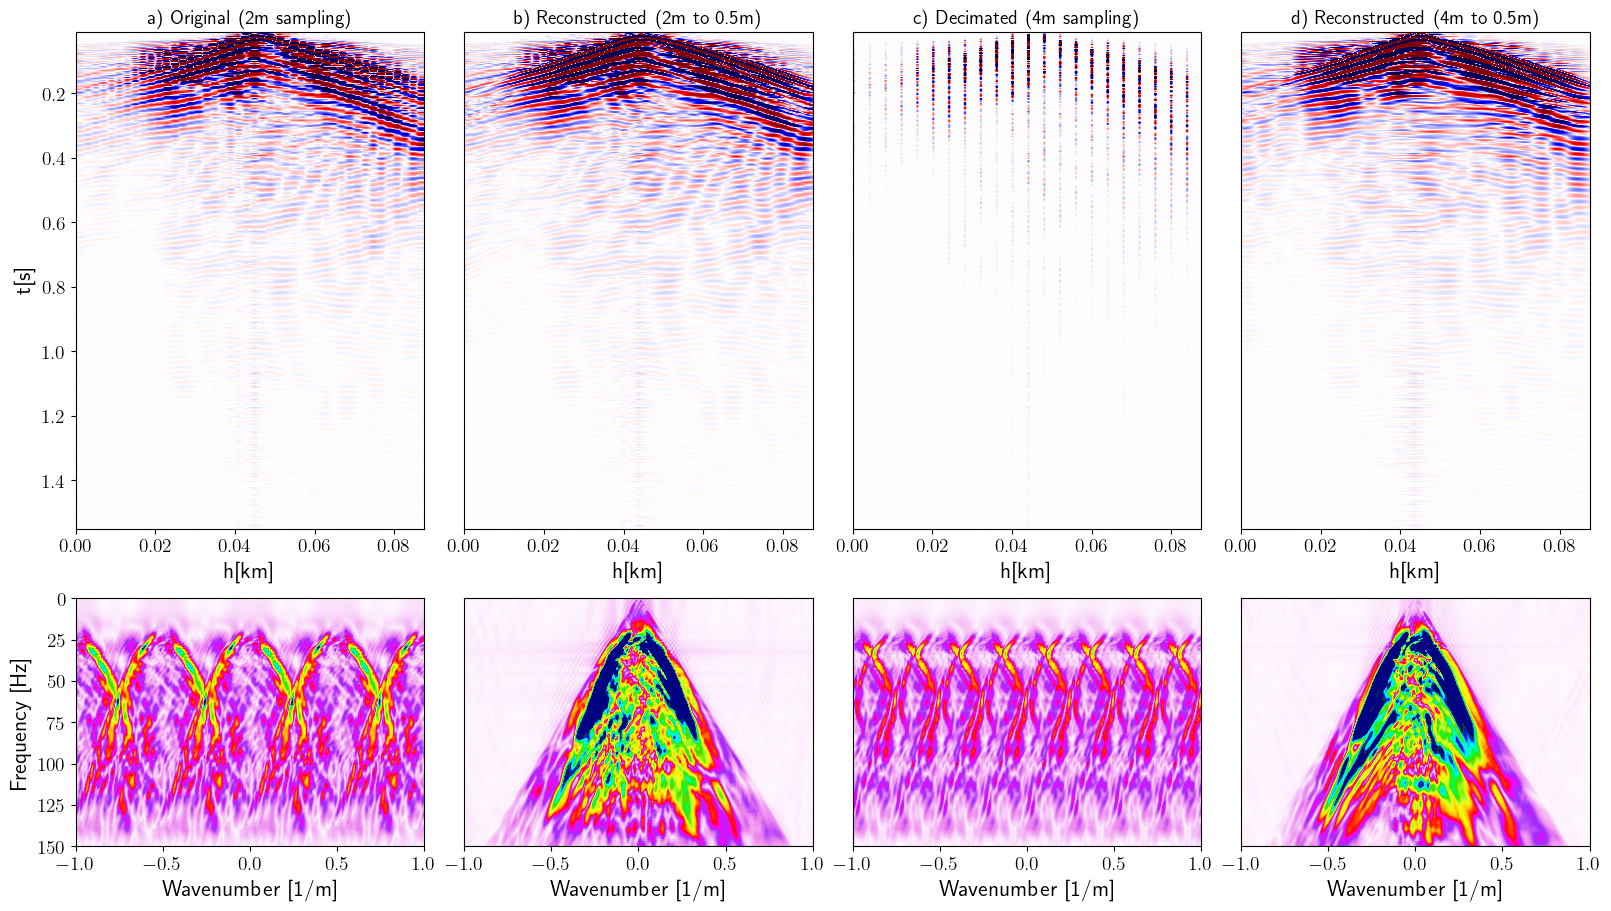

In [27]:
from pylops.utils.metrics import snr
show_seis_kwargs = dict(aspect='auto',cmap='seismic',vmin=-clip_v,vmax=clip_v,extent=(x[0]/1000, x[-1]/1000, t[-1], t[10]))
show_fk_kwargs = dict(cmap='gist_ncar_r',aspect='auto', 
                      extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]),vmin=0,vmax=clip_fk)

def plotting_style():
    """Plotting syle

    Define plotting style for the entire project

    """
    SMALL_SIZE = 10
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.style.use('default')

    plt.rc('text', usetex=True)
    plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('font', serif='Arial')  # fontsize of the figure title
plotting_style()

fig = plt.figure(constrained_layout=True, figsize=(16, 9))
axs = []
gs = fig.add_gridspec(3, 4)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[:2, 2]))
axs.append(fig.add_subplot(gs[:2, 3]))
axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))
axs.append(fig.add_subplot(gs[2:, 2]))
axs.append(fig.add_subplot(gs[2:, 3]))

axs[0].imshow((data).T, **show_seis_kwargs)
axs[0].set_title('a) Original (2m sampling)', fontsize=14)
axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')

axs[1].imshow((maskt2m*xinv2m).T, **show_seis_kwargs)
axs[1].set_title('b) Reconstructed (2m to 0.5m)', fontsize=14)
axs[1].axis('tight')
axs[1].set_xlabel('h[km]')

axs[2].imshow((data_mask4m).T, **show_seis_kwargs)
axs[2].set_title('c) Decimated (4m sampling)', fontsize=14)
axs[2].axis('tight')
axs[2].set_xlabel('h[km]')

axs[3].imshow((maskt4m*xinv4m).T, **show_seis_kwargs)
axs[3].set_title('d) Reconstructed (4m to 0.5m)', fontsize=14)
axs[3].axis('tight')
axs[3].set_xlabel('h[km]')

axs[4].imshow(np.fft.fftshift(np.abs((D).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs )
axs[4].set_xlim(-1/(2*dx), 1/(2*dx))
axs[4].set_ylim(150, f[0])
axs[4].set_xlabel('Wavenumber [1/m]')
axs[4].set_ylabel('Frequency [Hz]')

axs[5].imshow(np.fft.fftshift(np.abs((Fop*(maskt2m*xinv2m).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[5].set_xlim(-1/(2*dx), 1/(2*dx))
axs[5].set_ylim(150, f[0])
axs[5].set_xlabel('Wavenumber [1/m]')

axs[6].imshow(np.fft.fftshift(np.abs((Fop*(data_mask4m).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[6].set_xlim(-1/(2*dx), 1/(2*dx))
axs[6].set_ylim(150, f[0])
axs[6].set_xlabel('Wavenumber [1/m]')

axs[7].imshow(np.fft.fftshift(np.abs((Fop*(maskt4m*xinv4m).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[7].set_xlim(-1/(2*dx), 1/(2*dx))
axs[7].set_ylim(150, f[0])
axs[7].set_xlabel('Wavenumber [1/m]')


for i in range(len(axs)):
    if i!=0 and i!=4:
        axs[i].set_yticks([], [])
plt.savefig(save_fig_folder+"Figure 3_Field data reconstruction.eps",format='eps')